In [73]:
import numpy as np
import pandas as pd
import os

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

In [6]:
orderdf = pd.read_csv('ignored_assets/orders.csv', parse_dates = [6,7])

In [3]:
counts = orderdf[['driver_id', 'order_id']][~pd.isnull(orderdf['driver_id'])].groupby(['driver_id']).count()

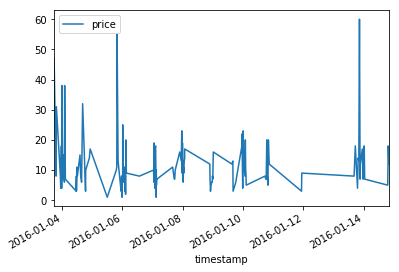

In [4]:
orderdf[orderdf['driver_id'] == '0003191f87382a164e4d8e0378e9ef05'][['price', 'timestamp']].set_index('timestamp').plot()

In [5]:
driver1 = orderdf[orderdf['driver_id'] == '0003191f87382a164e4d8e0378e9ef05']

In [6]:
driver1['hour'] = driver1['timestamp'].dt.hour
driver1['dayofweek'] = driver1['timestamp'].dt.dayofweek

/Users/ramoniglesias/development/cs341/venv/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ramoniglesias/development/cs341/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
ptable = pd.pivot_table(driver1, index = ['hour'], columns=['dayofweek'], values = ['order_id'],aggfunc=len)

In [8]:
ptable

order_id                              
dayofweek        0    1    2    3    4    5    6
hour                                            
0              3.0  NaN  5.0  6.0  4.0  2.0  2.0
1              4.0  NaN  5.0  5.0  3.0  NaN  2.0
2              1.0  NaN  4.0  3.0  NaN  NaN  3.0
3              NaN  NaN  1.0  3.0  NaN  NaN  NaN
11             5.0  1.0  NaN  NaN  NaN  NaN  NaN
12             1.0  NaN  NaN  NaN  NaN  NaN  NaN
13             NaN  NaN  1.0  NaN  NaN  NaN  NaN
14             2.0  NaN  NaN  NaN  NaN  NaN  NaN
15             2.0  NaN  NaN  1.0  NaN  2.0  NaN
16             1.0  NaN  1.0  NaN  NaN  1.0  NaN
17             NaN  NaN  1.0  3.0  NaN  NaN  2.0
18             2.0  NaN  NaN  NaN  NaN  2.0  3.0
19             NaN  3.0  2.0  2.0  NaN  NaN  5.0
20             NaN  1.0  2.0  1.0  NaN  NaN  2.0
21             1.0  NaN  2.0  1.0  2.0  NaN  NaN
22             3.0  3.0  1.0  1.0  2.0  NaN  2.0
23             NaN  5.0  2.0  3.0  4.0  5.0  4.0

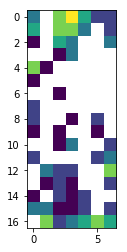

In [9]:
plt.imshow(ptable)

In [10]:
orderdf['hour'] = orderdf['timestamp'].dt.hour
orderdf['dayofweek'] = orderdf['timestamp'].dt.dayofweek

In [11]:
bigtable = pd.pivot_table(orderdf, index = ['hour'], columns=['driver_id'], values = ['order_id'],aggfunc=len)

In [12]:
sums = bigtable.fillna(0).as_matrix().sum(axis=0)

In [13]:
plt.plot(np.cumsum(sums[sort_indices]))

NameError: name 'sort_indices' is not defined

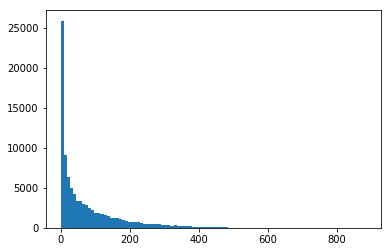

In [14]:
plt.hist(sums, bins = 100);

In [15]:
sort_indices = np.argsort(sums)[::-1]

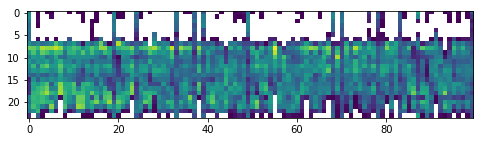

In [74]:
plt.imshow(bigtable.as_matrix()[:,sort_indices[:100]])

In [17]:
bigtable.as_matrix()[:,sort_indices[10]]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  53.,  68.,  63.,  49.,
        34.,  59.,  47.,  36.,  34.,  69.,  66.,  66.,  39.,  42.,  29.,
        15.,  nan])

In [18]:
early_sums = bigtable.fillna(0).as_matrix()[:6,:].sum(axis=0)
early_birds = np.argsort(early_sums)[::-1]

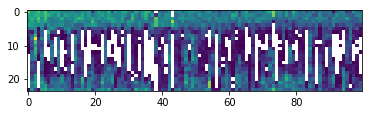

In [19]:
plt.imshow(bigtable.as_matrix()[:,early_birds[:100]])

## Clustering based on hour of operation

Let's cluster them based on when they prefer to work. There are two options, to include _also_ how often they work, or to simply regularize their frequency. Let's start by using both.

### KMeans by hour, unnormalized

In [67]:
sample = bigtable.fillna(0).as_matrix().T

In [68]:
nclusters = 5
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(sample)

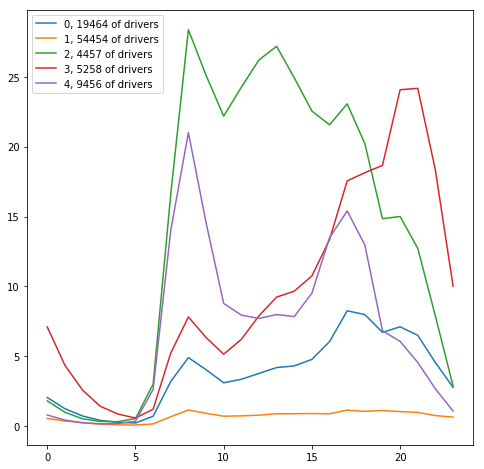

In [75]:
for i in range(nclusters):
    plt.plot(kmeans.cluster_centers_[i], label=str(i) + ', ' + str(np.sum(kmeans.labels_ == i)) + ' of drivers')

plt.legend()

So, it seems that it did catch some patterns, let's see how consistent are the distributions. 

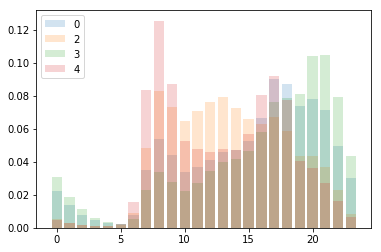

In [23]:
for i in range(nclusters):
    if i in [1]: continue
        
    distr = sample[kmeans.labels_ == i].sum(axis=0) / sample[kmeans.labels_ == i].sum(axis=0).sum()
    plt.bar(range(24),distr, alpha=0.2, label=str(i))

plt.legend()

### KMeans by hour, normalized

In [24]:
# normalized and smoothed
s = 5
norm_sample = (sample + s) / (sample.sum(axis=1)[:,None] + s*24)

In [25]:
nclusters = 5
norm_kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(norm_sample)

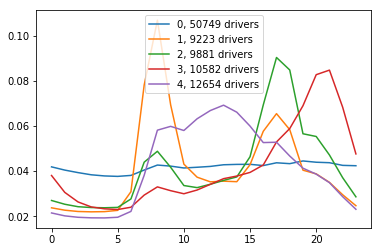

In [26]:
for i in range(nclusters):
    plt.plot(norm_kmeans.cluster_centers_[i], label=str(i) + ', ' + str(np.sum(norm_kmeans.labels_ == i)) + ' drivers')

plt.legend()

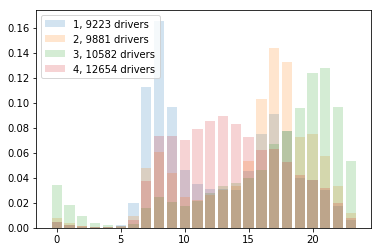

In [27]:
for i in range(nclusters):
    if i ==0: continue
        
    distr = sample[norm_kmeans.labels_ == i].sum(axis=0) / sample[norm_kmeans.labels_ == i].sum(axis=0).sum()
    plt.bar(range(24),distr, alpha=0.2, label=str(i) + ', ' + str(np.sum(norm_kmeans.labels_ == i)) + ' drivers')

plt.legend()

The normalized and smoothed version works much better. The smoothing helps catching the lousy drivers and that way we can discarded. 

In [360]:
cumdistr = np.cumsum(sums[sort_indices]) / sums.sum()
plt.plot(cumdistr)
sorted_labels = norm_kmeans.labels_[sort_indices]
plt.scatter(np.argwhere(sorted_labels == 0),cumdistr[sorted_labels == 0], marker='x', color='green', alpha=0.5)

IndexError: index 460359 is out of bounds for axis 1 with size 93089

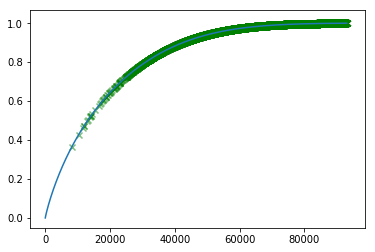

In [316]:
cumdistr = np.cumsum(sums[sort_indices]) / sums.sum()
plt.plot(cumdistr)
sorted_labels = kmeans.labels_[sort_indices]
plt.scatter(np.argwhere(sorted_labels == 1),cumdistr[sorted_labels == 1], marker='x', color='green', alpha=0.5)

While the smoothed version is able to better capture specific behaviors, it takes from the entire set, and can only distinguish the behaviors from those with sufficient rides. The unnormalized is able to capture both behavior and the different 

In [48]:
match = {did[1]: kmeans.labels_[i] for i,did in enumerate(bigtable.columns)}

In [62]:
def assign_driver_label(dids):
    labels = np.zeros(len(dids), dtype=object)
    for i,did in enumerate(dids):
        if pd.isnull(did):
            labels[i] = np.nan
        else:
            labels[i] = match[did]
    return labels
    

In [63]:
orderdf['driver_cluster'] = assign_driver_label(orderdf['driver_id'])

In [65]:
orderdf.to_csv('ignored_assets/orders.csv', index = False)

### Rider Clustering

In [320]:
paxtable = pd.pivot_table(orderdf, index = ['hour'], columns=['passenger_id'], values = ['order_id'],aggfunc=len)

In [324]:
paxsums = paxtable.fillna(0).as_matrix().sum(axis=0)

In [325]:
paxsort_indices = np.argsort(sums)[::-1]

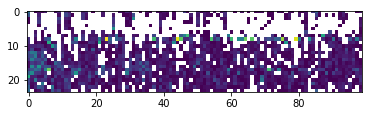

In [328]:
plt.imshow(paxtable.as_matrix()[:,sort_indices[1:100]])

In [329]:
paxearly_sums = paxtable.fillna(0).as_matrix()[:6,:].sum(axis=0)
paxearly_birds = np.argsort(paxearly_sums)[::-1]

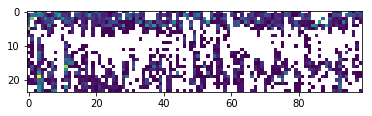

In [331]:
plt.imshow(paxtable.as_matrix()[:,paxearly_birds[1:100]])

### Kmeans passenger, unnormalized

In [332]:
paxsample = paxtable.fillna(0).as_matrix().T

In [346]:
nclusters = 4
pax_kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(paxsample)

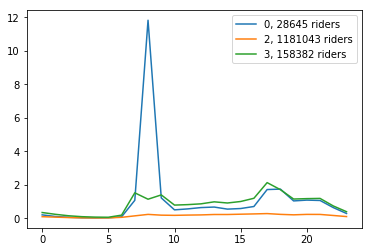

In [359]:
for i in range(nclusters):
    if i == 1: continue
    plt.plot(pax_kmeans.cluster_centers_[i], label=str(i) + ', ' + str(np.sum(pax_kmeans.labels_ == i)) + ' riders')

plt.legend()

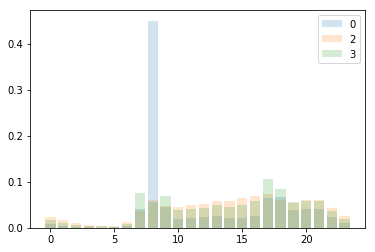

In [357]:
for i in range(nclusters):
    if i in [1]: continue
        
    distr = paxsample[pax_kmeans.labels_ == i].sum(axis=0) / paxsample[pax_kmeans.labels_ == i].sum(axis=0).sum()
    plt.bar(range(24),distr, alpha=0.2, label=str(i))

plt.legend()

(array([  7.19074000e+05,   2.57838000e+05,   1.33386000e+05,
          7.86160000e+04,   5.13490000e+04,   3.49960000e+04,
          2.46020000e+04,   1.78010000e+04,   1.33580000e+04,
          9.83500000e+03,   7.42800000e+03,   5.44700000e+03,
          3.97300000e+03,   2.88200000e+03,   2.11300000e+03,
          1.49600000e+03,   1.09400000e+03,   7.52000000e+02,
          5.78000000e+02,   3.96000000e+02,   3.09000000e+02,
          2.00000000e+02,   1.33000000e+02,   9.10000000e+01,
          7.80000000e+01,   5.80000000e+01,   4.20000000e+01,
          2.90000000e+01,   1.40000000e+01,   1.30000000e+01,
          1.50000000e+01,   1.60000000e+01,   1.00000000e+01,
          9.00000000e+00,   7.00000000e+00,   4.00000000e+00,
          5.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
        

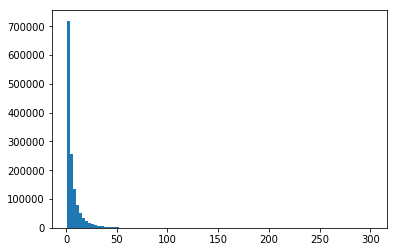

In [368]:
plt.hist(paxsums[paxsums != paxsums.max()], bins = 100)